<a href="https://colab.research.google.com/github/Tobias-Fischer/RVSS/blob/main/Robotic_Vision/image_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table>
  <tr>
    <td><div align="left"><font size="30">Image Features</font></div></td>
    <td><img src="https://github.com/Tobias-Fischer/RVSS2022/blob/main/Robotic_Vision/common/RVSS-logo.png?raw=1" width="400"></td>
  </tr>
</table>

## Configuring CoLab
To make this run nicely in CoLab we have to install a bunch of packages. This will be slow and at the end you will need to restart the kernel. Push the RESTART KERNEL button that appears or from the menu above Runtime/RestartRuntime

In [1]:
!pip uninstall opencv-contrib-python --yes
!pip uninstall opencv-python --yes

Found existing installation: opencv-contrib-python 4.6.0.66
Uninstalling opencv-contrib-python-4.6.0.66:
  Successfully uninstalled opencv-contrib-python-4.6.0.66
Found existing installation: opencv-python 4.6.0.66
Uninstalling opencv-python-4.6.0.66:
  Successfully uninstalled opencv-python-4.6.0.66


In [1]:
# !pip install opencv-python-headless==4.5.5.*
# !pip install opencv-contrib-python-headless==4.5.5.*
# !pip install spatialmath-python

!pip install matplotlib==3.5
!pip install machinevision-toolbox-python

# !pip install mvtb-data
# !pip install -U ipython


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, we can import some of the packages we need throughout, NumPy, and configure the CoLab environment a bit.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 8]

import numpy as np
import math
from machinevisiontoolbox import Image, Kernel
from spatialmath.base import plot_point


We will work with the greyscale Mona Lisa image

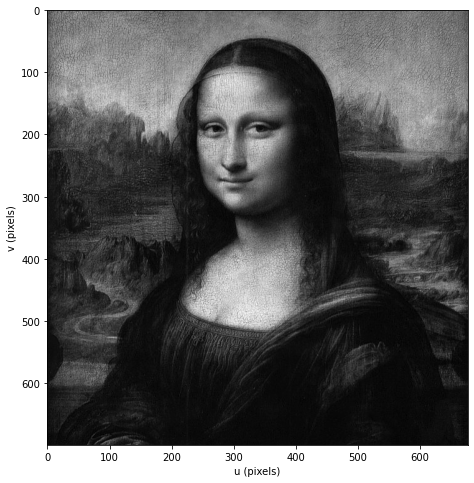

In [3]:
mona = Image.Read('monalisa.png', grey=True)
mona.disp();

# Histogram

We can show the distribution of grey values within the image

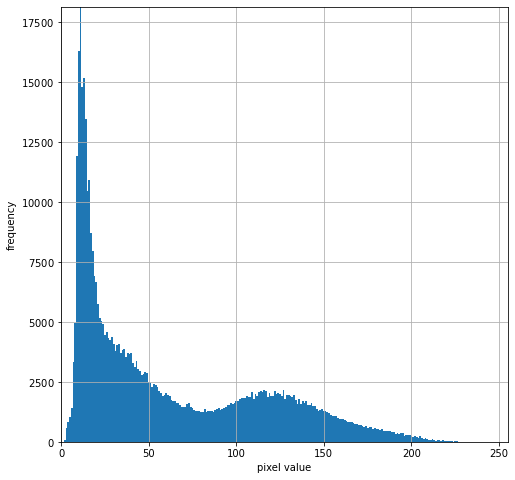

In [5]:
mona.hist().plot()

and also display some simple statistics of those grey values

In [6]:
mona.stats()

range=1 - 233, mean=61.271, sdev=52.380


# Spatial operators
## Image smoothing by averaging

The image of the Mona Lisa looks rather grainy, the paint is cracked, but she is over 500 years old...

We could smooth it out by local averaging, where every pixel in the output image is the average of all pixels in a $5 \times 5$ window about the corresponding input pixel.  We first create a kernel

In [11]:
kernel = np.ones((5,5),np.float32) / 25
kernel

array([[0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, 0.04, 0.04]], dtype=float32)

where the sum of all values is equal to one.  For a given input pixel, say (20,30), the $5 \times 5$ window is

In [12]:
window = mona.image[30-2:30+3,20-2:20+3]
window

array([[119, 124,  98, 117, 106],
       [120,  87, 112, 129, 139],
       [134,  78, 114,  86, 126],
       [112,  84, 100, 106, 103],
       [117,  89, 134,  95, 124]], dtype=uint8)

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">Note that we swapped the 20 and 30.  (20,30) means the horizontal coordinate is 20 and the vertical coordinate is 30, but when we index into a 2D array the first index is row (vertical direction) and the second index is column (horizontal direction).</p>
<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">Note that the range 30-2:30+3 includes 30-2, 30-1, 30-0, 30+1, 30+2.  In Python the end value of  a range is not included in the set.</p>

In [13]:
z = window * kernel
z

array([[4.7599998, 4.96     , 3.9199998, 4.68     , 4.24     ],
       [4.7999997, 3.48     , 4.48     , 5.16     , 5.56     ],
       [5.3599997, 3.12     , 4.56     , 3.4399998, 5.04     ],
       [4.48     , 3.36     , 4.       , 4.24     , 4.12     ],
       [4.68     , 3.56     , 5.3599997, 3.8      , 4.96     ]],
      dtype=float32)

In [14]:
np.sum(z)

110.119995

and this is the value of pixel (20,30) in the output image.  

We need do this for every pixel in the image, and we could use a pair of nested `for` loops but that's not very efficient.  We can use optimised code in OpenCV

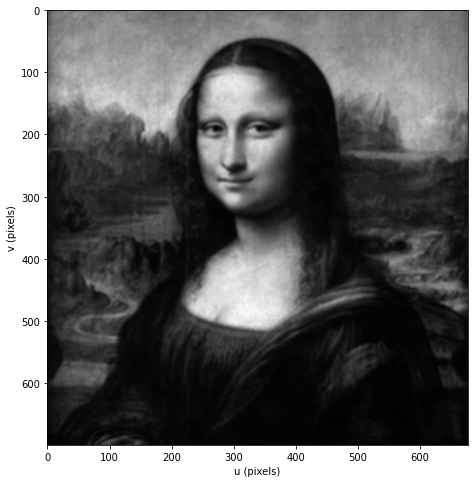

In [15]:
smoothed = mona.convolve(kernel)
smoothed.disp();

**Q: Vary the dimensions of the kernel to see what effect it has?**

## Gaussian blur

For image smoothing it is preferable to use a kernel that is isotropic and symmetric such as a 2D Gaussian

$G(u,v) = \frac{1}{2\pi\sigma^2}e^{-\frac{u^2+v^2}{2\sigma^2}}$

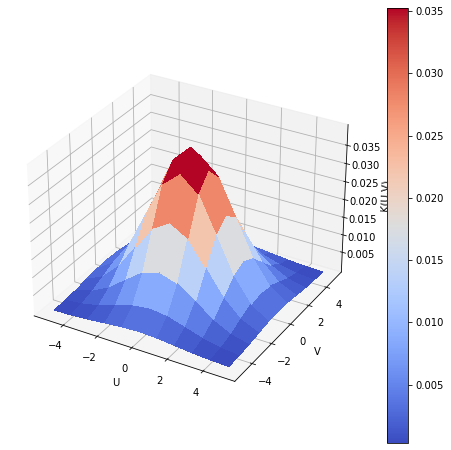

In [23]:
w = 5
k = range(-w, w+1)
sigma = 2
[U,V] = np.meshgrid(k, k)
kernel = 1/(2*math.pi*sigma**2)*np.exp(-(U**2+V**2)/(2*sigma**2))
kernel
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
ax = plt.axes(projection='3d')
surf = ax.plot_surface(U, V, kernel, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, ax=ax)
ax.set_xlabel('U')
ax.set_ylabel('V')
ax.set_zlabel('K(U,V)');

We can blur our image with this kernel

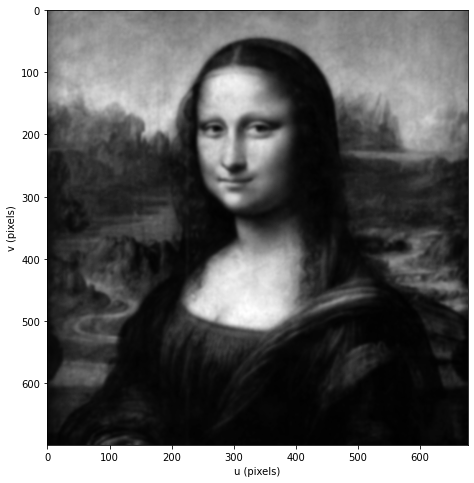

In [24]:
smoothed = mona.convolve(kernel)
smoothed.disp();

We can do this in a single step where we pass in the image

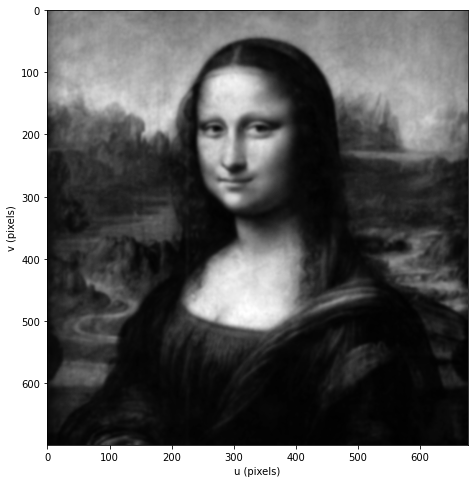

In [25]:
blur = mona.smooth(2, 5)
blur.disp();

### Exercises

* **Vary the dimensions of the kernel to see what effect it has**
* **Vary the standard deviation**

## Finding edges
We can use 2D filtering to find edges as well.  This convolution kernel will find vertical edges.  The intuition is that each row of this kernel subtracts the pixel to the left from the pixel to the right, which will give a positive value if the intensity is increasing left to right.

In [26]:
kernel = np.array( [ [1, 0, -1],
                     [2, 0, -2],
                     [1, 0, -1] ]) / 8

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">You may often see this filter kernel written with the first and third columns swapped.  This is appropriate if you perform correlation, not convolution. These are two similar operations but differ in the kernel being reflected about its centre.  Many kernels are symmetric which means that convolution and correlation are the same.</p>

In [ ]:
penguins = Image.Read('penguins.png', grey=True, dtype='float')
penguins.disp();

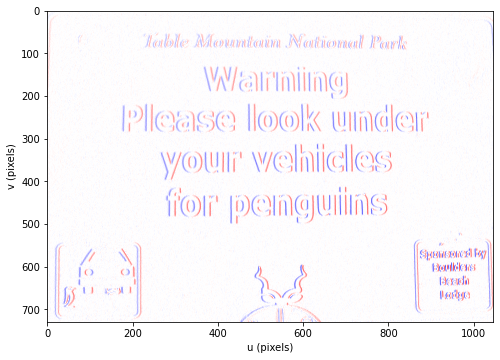

In [28]:
gradient_horizontal = penguins.convolve(kernel)
gradient_horizontal.disp(colormap='signed');                

The image is displayed with a color map that shows negative numbers as red and positive numbers as blue.  Zoom in on the outline of the "P" (use the second button from the right in the bottom toolbar) and you can see that the intensity goes up (blue) on the left side of the "P", from the grey background to the white paint. It goes down (red) on right of the stem, from the white paint to the gray background.

<p style="border:3px; border-style:solid; border-color:#FF0000; padding: 1em;">Our original image comprised unsigned integers (uint8) which are unable to express negative values.  The output of convolve() is a signed floating point image meaning the result at each pixel, can be positive or negative.</p>

We can find the horizontal edges by finding vertical gradient, using the transpose of the kernel

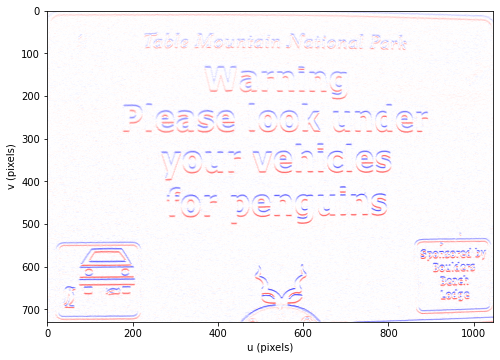

In [29]:
gradient_vertical = penguins.convolve(kernel.T)
gradient_vertical.disp(colormap='signed');    

# Harris corner features
## From first principles

We now have all the ingredients (and knowledge) needed to find interest points.

In [30]:
castle = Image.Read('castle.png', grey=True, dtype='float')

The fundamental intuition behind interest points is that they have a high gradient in two orthogonal directions, but not necessarily the u- and v-axis directions.

However we start by computing the gradient in the u- and v-axis directions and then for every pixel compute this matrix

$\mathbf{A} = \begin{pmatrix} \mathbf{G}_\sigma * \mathbf{I}_u^2  & \mathbf{G}_\sigma * \mathbf{I}_u \mathbf{I}_v \\ \mathbf{G}_\sigma * \mathbf{I}_u \mathbf{I}_v & \mathbf{G}_\sigma * \mathbf{I}_v^2 \end{pmatrix}$

This $2 \times 2$ symmetric matrix is called the structure tensor.
It captures the intensity structure of the local neighborhood and its eigenvalues provide a rotationally invariant description of the neighborhood. The elements of the $\mathbf{A}$ matrix are computed from the image gradients, squared or multiplied, and then smoothed using a weighting matrix. The latter reduces noise and improves the stability and reliability of the detector.

In [31]:
# compute derivatives

kernel = Kernel.Sobel()

Iu = castle.convolve(kernel)
Iv = castle.convolve(kernel.T)

# make a Gaussian smoothing kernel 11x11 with sigma=1
w2 = 5  # half width
k = range(-w2, w2+1)
sigma = 1
[U,V] = np.meshgrid(k, k)
kgaussian = 1.0 / (2 * math.pi * sigma**2) * np.exp(-(U**2 + V**2) / (2 * sigma**2))

# could also use kgaussian = kgauss(sigma, w2)

# compute the 3 unique elements of the structure tensor
Ix = (Iu * Iu).convolve(kgaussian)
Iy = (Iv * Iv).convolve(kgaussian)
Ixy = (Iu * Iv).convolve(kgaussian)

An interest point $(u, v)$ is one where whatever direction we move the window it rapidly becomes dissimilar to the original region. If we consider the original image $\mathbf{I}$ as a surface the eigenvalues of $\mathbf{A}$ are the principal curvatures of the surface at that point: 

* If both eigenvalues are small then the surface is flat, that is the image region has approximately constant local intensity. 
* If one eigenvalue is high and the other low, then the surface is ridge shaped which indicates an edge. 
* If both eigenvalues are high the surface is sharply peaked which we consider to be a corner.

The well known Shi-Tomasi detector considers the strength of the corner, or cornerness, as the minimum eigenvalue

$C_{\text{ST}}(u,v) = \min( \lambda_1, \lambda_2)$

where $\lambda_i$ are the eigenvalues of $\mathbf{A}$. Points in the image for which this measure is high are referred to as ["good features to track"](http://www.ai.mit.edu/courses/6.891/handouts/shi94good.pdf). 

The Harris detector is based on this same insight but defines corner strength as

$C_{H}(u,v) = \det(\mathbf{A}) - k \text{trace}(\mathbf{A})$

and again a large value represents a strong, distinct, corner. Since $\det(A) = \lambda_1  \lambda_2$ and
$\text{trace}(A) = \lambda_1 + \lambda_2$ the Harris detector responds when both eigenvalues are large and elegantly avoids computing the eigenvalues of A which has a somewhat higher computational cost.  Typically $k=0.04$.

We compute this for all pixels at once

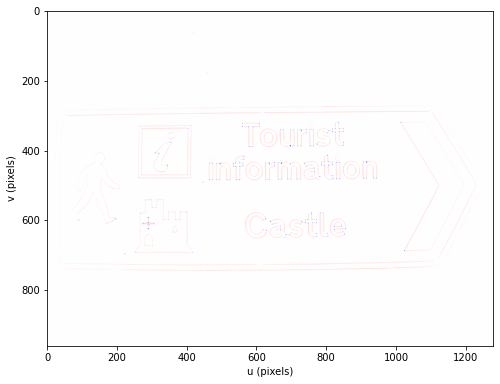

In [32]:
rawC = (Ix * Iy - Ixy * Ixy) - 0.04 * (Ix + Iy)**2
rawC.disp(colormap='signed');

which shows the raw value of $C_H$. If we zoom in and examine the image we will see that large areas of smooth background are around zero, edges are negative and corners of things (like the letters) have a positive value.

Next we need to find the coordinates of those positive patches values.  For every pixel we find the largest value in a $5\times 5$ window around each pixel but not including the centre pixel itself.

In [33]:
# create the structuring element
SE = np.ones((5,5), np.uint8)
SE[2,2] = 0

# find the maximum value around each pixel
surrounding_max = rawC.dilate(SE)

We've done this using a morphological filtering operation called dilation, you can find more details from the documentation page for [`dilate`](https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c).

Next we find all the pixels whose value is greater than those surrounding it (which we just computed). This is a common trick in computer vision when we are looking for peaks &ndash; it's called non-local maxima suppresion.

1048520 peaks found



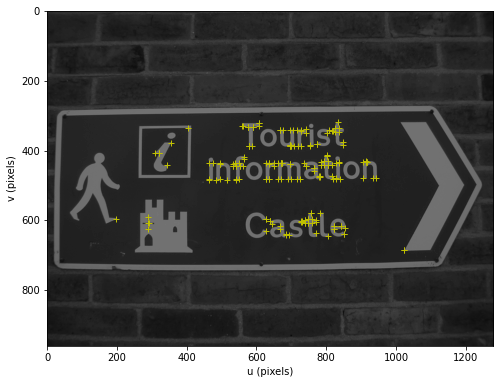

In [34]:
uv = (rawC > surrounding_max).nonzero()  # find the indices of all the peaks
peakvals = rawC.image[uv[1,:], uv[0,:]]  # find the peak values
k = np.argsort(-peakvals)  # sort those values into descending order
print('%d peaks found\n' % (len(k),))  # report how many peaks were found
k = k[:200]  # take first 200, these are the strongest peaks

# find the u, v coordinates as two separate lists
u = np.array([uv[0][i] for i in k])
v = np.array([uv[1][i] for i in k])

# display the image, and overlay with markers for each detected corner feature
castle.disp(darken=True, block=None);
plot_point((u, v), 'y+');

Zoom in on the letters and you will see that the features are placed on sharp corners.

### Summary

Developed by Chris Harris and Mike Stephens in 1988 the [Harris detector](https://en.wikipedia.org/wiki/Harris_Corner_Detector) was THE detector used in computer vision until
[SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform) was developed by David Lowe in 1999.
SIFT is very powerful (it has the very useful property called scale-invariance which we won't have time to cover) but was [patented by the University of British Columbia](https://patents.google.com/patent/US6711293) and researchers were therefore reluctant to be too dependent on it. [SURF](https://en.wikipedia.org/wiki/Speeded_up_robust_features) was  developed by Herbert Bay, Tinne Tuytelaars, and Luc Van Gool and published in 2006. It has similar functionality to SIFT but is much faster.  It turns out that [SURF was also patented](https://worldwide.espacenet.com/patent/search/family/036954920/publication/US2009238460A1?q=pn%3DUS2009238460) but people seemed to worry less about that.  Now the SIFT patent has expired so it is back in favour.  OpenCV ships with SIFT but not SURF.

# SIFT features

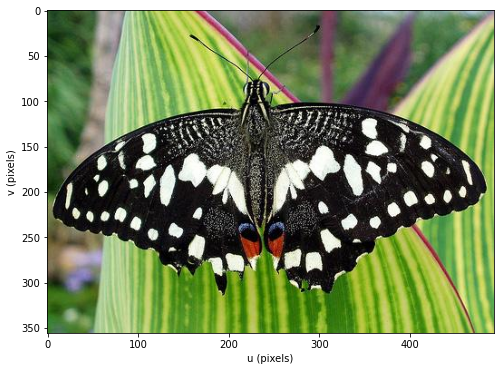

In [35]:
butterfly = Image.Read('butterfly.jpg')
butterfly.disp();

Now we can find SIFT features in this scene

In [36]:
features = butterfly.SIFT()

which is another type of object that contains data about all the features, it behaves a bit like a list

In [37]:
len(features)

1064

and in this case there are 1055 features found.

Each feature (sometimes called keypoints) has a number of characteristics

In [38]:
features[0]

SIFTFeature: (10.9, 29.9), strength=0.01, scale=9.8, orient=0.9°, id=-1

which are also attributes of the object.  For example the centroid is

In [39]:
features[0].p

array([[10.91496181],
       [29.87049866]])

Unlike the Harris feature, the SIFT feature also has a size (in pixels)

In [40]:
features[0].scale

9.79962158203125

as well as a characteristic angle

In [41]:
features[0].orientation

0.9145068814639448

in degrees.

Each feature also strength or response (similar to "cornerness" for the Harris detector) that indicates how unique the feature is

In [42]:
features[0].strength

0.014013596810400486

The first 10 SIFT features are

In [43]:
features[:10].table()

┌──┬─────────────┬──────────┬───────┬────────┬────┐
│# │    centroid │ strength │ scale │ orient │ id │
├──┼─────────────┼──────────┼───────┼────────┼────┤
│0 │  10.9, 29.9 │    0.014 │   9.8 │ 0.915° │ -1 │
│1 │  10.9, 29.9 │    0.014 │   9.8 │  4.64° │ -1 │
│2 │ 11.5, 330.5 │   0.0192 │  9.91 │ 0.505° │ -1 │
│3 │ 15.2, 170.1 │   0.0135 │  8.31 │  5.44° │ -1 │
│4 │ 17.2, 152.1 │   0.0156 │  10.3 │  2.48° │ -1 │
│5 │ 17.2, 152.1 │   0.0156 │  10.3 │  5.45° │ -1 │
│6 │ 19.7, 234.6 │   0.0282 │  2.57 │  2.43° │ -1 │
│7 │ 21.4, 180.2 │   0.0266 │  5.93 │   3.9° │ -1 │
│8 │ 21.9, 190.2 │   0.0435 │  3.31 │ 0.851° │ -1 │
│9 │  23.2, 94.4 │   0.0173 │  14.5 │  6.11° │ -1 │
└──┴─────────────┴──────────┴───────┴────────┴────┘



and they are essentially in the order they were encountered in the image.  We are often interested in the N strongest features, so we would first sort the features into descending order by strength

In [44]:
features = features.sort()

and now the first 10 are

In [45]:
features[:10].table()

┌──┬──────────────┬──────────┬────┐
│# │     centroid │ strength │ id │
├──┼──────────────┼──────────┼────┤
│0 │ 381.9, 220.0 │    0.134 │ -1 │
│1 │ 381.9, 220.0 │    0.134 │ -1 │
│2 │ 381.9, 220.0 │    0.134 │ -1 │
│3 │ 381.9, 220.0 │    0.134 │ -1 │
│4 │ 422.0, 208.5 │    0.133 │ -1 │
│5 │ 422.0, 208.5 │    0.133 │ -1 │
│6 │ 422.0, 208.5 │    0.133 │ -1 │
│7 │ 361.7, 233.8 │    0.132 │ -1 │
│8 │ 361.7, 233.8 │    0.132 │ -1 │
│9 │ 361.7, 233.8 │    0.132 │ -1 │
└──┴──────────────┴──────────┴────┘



We can plot the features, their size and orientation

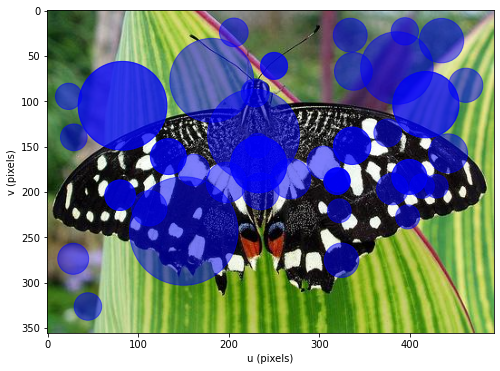

In [46]:
butterfly.disp(block=None)
features.sort(by='scale')[:50].plot(filled=True, alpha=0.5)

where each feature is denoted by a translucent disk that indicates the position and scale of the feature.  Clearly it has found the distinctive points in the image.

**Q: Compute and plot a histogram of the feature scales.**

Each feature point has a descriptor which is a summary of the pixel values within the variable size disk surrounding it. This is given by the descriptor which is a vector of 64 floats


In [47]:
features[0].descriptor

array([ 53.,  51.,  39.,  15.,  18.,  19.,  25.,  43.,   4.,   9.,  29.,
        50.,  98.,  61.,  30.,   9.,   7.,  11.,   0.,   1.,  13.,  16.,
        22.,   1.,  22.,  33.,   9.,   1.,   0.,   1.,   1.,  10.,  20.,
        34.,  50.,  13.,  34.,  49.,  10.,   8.,  86.,  28.,  39.,  32.,
        15.,  20.,  89., 107.,   5.,   5.,   6.,  22.,  87., 107., 104.,
        22.,   4.,  24.,   5.,   1.,  24.,  17.,   2.,   0.,  13.,   7.,
         1.,   3.,  90., 107.,  21.,   3.,  89., 107.,  84.,  20.,  27.,
        14.,   8.,  26.,  30.,  27.,  70.,  89.,  82.,  41.,  67.,  55.,
         1.,   1.,   0.,   3.,  42.,  88.,  69.,   7.,   1.,   0.,   1.,
        13., 103.,  55.,  16.,   3.,  37.,  25.,  13.,   3.,  39.,  68.,
        17.,   4., 107.,  91.,  38.,  19.,   8.,  11.,  30.,  58.,   3.,
         8.,  24.,  86.,  84.,  52.,  26.,   9.], dtype=float32)

If we moved the camera to shrink the image by a factor of two the size of all the support region disks would reduce by a factor of two, but the descriptor would remain approximately constant.  If we rotated the camera by 90degrees the characteristic angle of all the features would change by 90degrees but the feature size and the descriptor would remain approximately constant.

We can display the orientation, along with the feature size and scale by

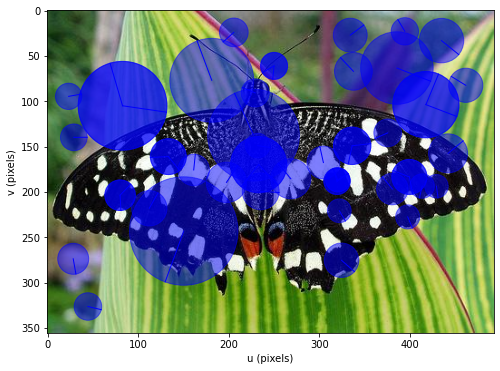

In [48]:
butterfly.disp(block=None)
features.sort(by='scale')[:50].plot(filled=True, alpha=0.5, hand=True)

where the blue line (like a one-handed clock) indicates the characteristic orientation.  Some features are doubled up, same position and scale, but different orientation.

# Finding correspondences between images

First we will load two different views of the same scene

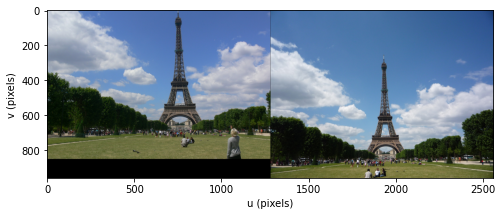

In [52]:
im1 = Image.Read('eiffel-1.png')
im2 = Image.Read('eiffel-2.png')
Image.Hstack((im1,im2)).disp()


and then use SIFT to find corresponding features in the two images

In [53]:
f1 = im1.SIFT()
f2 = im2.SIFT()

Then we create a "*match*" object and give it the two sets of features.  It finds the best matches and for each match computes a `distance` which is a measure of dissimilarity.  We sort the matches into decreasing similarity

In [55]:
matches = f1.match(f2)
matches

805 matches

then plot the best 100 matches.  The `plot` method renders the matches onto the original images and overlays lines that connect corresponding points

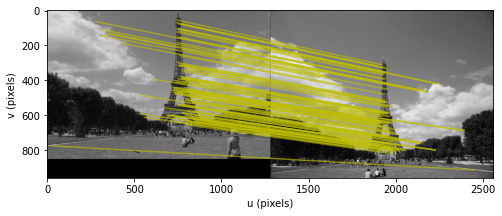

In [56]:
matches[:100].plot('y', alpha=0.6, block=None)

Zoom in and see how well it has done.

Finding corresponding points in a pair of images is critical to a lot of important computer vision problems such as stereo, structure from motion and visual SLAM.